# Download Data

In [1]:
# !wget https://hkustconnect-my.sharepoint.com/:u:/g/personal/nnanda_connect_ust_hk/ERROCEL56mNPqSWWzbzLj3cBvQTtCS9yzoiUfVlhIx1CCA?download=1 -O "data_2021_spring.zip"
!wget https://hkustconnect-my.sharepoint.com/:u:/g/personal/nnanda_connect_ust_hk/EfREjZqiZTlPqhqUPICBbPABdlgPumlaUVxPncm-_9aWIw?download=1 -O "Project 1 - data.zip"
!unzip "Project 1 - data.zip"


--2021-03-27 01:35:35--  https://hkustconnect-my.sharepoint.com/:u:/g/personal/nnanda_connect_ust_hk/EfREjZqiZTlPqhqUPICBbPABdlgPumlaUVxPncm-_9aWIw?download=1
Resolving hkustconnect-my.sharepoint.com (hkustconnect-my.sharepoint.com)... 13.107.136.9
Connecting to hkustconnect-my.sharepoint.com (hkustconnect-my.sharepoint.com)|13.107.136.9|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/nnanda_connect_ust_hk/Documents/COMP4332%20Project%20Data/Project%201%20-%20data.zip?originalPath=aHR0cHM6Ly9oa3VzdGNvbm5lY3QtbXkuc2hhcmVwb2ludC5jb20vOnU6L2cvcGVyc29uYWwvbm5hbmRhX2Nvbm5lY3RfdXN0X2hrL0VmUkVqWnFpWlRsUHFocVVQSUNCYlBBQmRsZ1B1bWxhVVZ4UG5jbS1fOWFXSXc_cnRpbWU9bUxXYm5zRHcyRWc [following]
--2021-03-27 01:35:35--  https://hkustconnect-my.sharepoint.com/personal/nnanda_connect_ust_hk/Documents/COMP4332%20Project%20Data/Project%201%20-%20data.zip?originalPath=aHR0cHM6Ly9oa3VzdGNvbm5lY3QtbXkuc2hhcmVwb2ludC5jb20vOnU6L2cvcGVyc29uYWwvbm5hbmRhX2Nvbm5lY3RfdXN0X2hrL0

# Import Libraries

In [2]:
!pip install keras-layer-normalization

  Created wheel for keras-layer-normalization: filename=keras_layer_normalization-0.14.0-cp37-none-any.whl size=5269 sha256=c24d17a0b6bef2ce7247d8847ca1aa1ab3d5e99d4a10575a7d0151a50dc0ee4e
  Stored in directory: /root/.cache/pip/wheels/54/80/22/a638a7d406fd155e507aa33d703e3fa2612b9eb7bb4f4fe667
Successfully built keras-layer-normalization


In [3]:
import os
import nltk
import math
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import Counter
from itertools import chain
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, BatchNormalization, Activation, Input, Add, Concatenate, Embedding, Conv1D, MaxPool1D, Flatten, LSTM, Bidirectional, MaxPooling1D
from keras_layer_normalization import LayerNormalization
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

In [4]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [5]:
stopwords = set(stopwords.words("english"))
ps = PorterStemmer()

# Data Loader

In [6]:
def load_data(split_name='train', columns=['text', 'stars']):
    try:
        print(f"select [{', '.join(columns)}] columns from the {split_name} split")
        df = pd.read_csv(f'data_2021_spring/{split_name}.csv')
        df = df.loc[:,columns]
        print("succeed!")
        return df
    except:
        print("Failed, then try to ")
        print(f"select all columns from the {split_name} split")
        df = pd.read_csv(f'data_2021_spring/{split_name}.csv')
        return df

In [7]:
train_df = load_data('train', columns=['full'])
valid_df = load_data('valid', columns=['full'])
test_df = load_data('test', columns=['full'])

select [full] columns from the train split
Failed, then try to 
select all columns from the train split
select [full] columns from the valid split
Failed, then try to 
select all columns from the valid split
select [full] columns from the test split
Failed, then try to 
select all columns from the test split


# Feature Extractor

In [8]:
def tokenize(text):
    """
    :param text: a doc with multiple sentences, type: str
    return a word list, type: list
    e.g.
    Input: 'Text mining is to identify useful information.'
    Output: ['Text', 'mining', 'is', 'to', 'identify', 'useful', 'information', '.']
    """
    return nltk.word_tokenize(text)

def stem(tokens):
    """
    :param tokens: a list of tokens, type: list
    return a list of stemmed words, type: list
    e.g.
    Input: ['Text', 'mining', 'is', 'to', 'identify', 'useful', 'information', '.']
    Output: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.']
    """
    ### equivalent code
    # results = list()
    # for token in tokens:
    #     results.append(ps.stem(token))
    # return results

    return [ps.stem(token) for token in tokens]

def n_gram(tokens, n=1):
    """
    :param tokens: a list of tokens, type: list
    :param n: the corresponding n-gram, type: int
    return a list of n-gram tokens, type: list
    e.g.
    Input: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.'], 2
    Output: ['text mine', 'mine is', 'is to', 'to identifi', 'identifi use', 'use inform', 'inform .']
    """
    if n == 1:
        return tokens
    else:
        results = list()
        for i in range(len(tokens)-n+1):
            # tokens[i:i+n] will return a sublist from i th to i+n th (i+n th is not included)
            results.append(" ".join(tokens[i:i+n]))
        return results
    
def filter_stopwords(tokens):
    """
    :param tokens: a list of tokens, type: list
    return a list of filtered tokens, type: list
    e.g.
    Input: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.']
    Output: ['text', 'mine', 'identifi', 'use', 'inform', '.']
    """
    ### equivalent code
    # results = list()
    # for token in tokens:
    #     if token not in stopwords and not token.isnumeric():
    #         results.append(token)
    # return results

    return [token for token in tokens if token not in stopwords and not token.isnumeric()]

In [9]:
def get_feats_dict(feats, min_freq=-1, max_freq=-1, max_size=-1):
    """
    :param data: a list of features, type: list(list)
    :param min_freq: the lowest fequency that the fequency of a feature smaller than it will be filtered out, type: int
    :param max_freq: the highest fequency that the fequency of a feature larger than it will be filtered out, type: int
    :param max_size: the max size of feature dict, type: int
    return a feature dict that maps features to indices, sorted by frequencies
    # Counter document: https://docs.python.org/3.6/library/collections.html#collections.Counter
    """
    # count all features
    feat_cnt = Counter(feats) # ["text", "text", "mine"] --> {"text": 2, "mine": 1}
    # .most_common(): List the n most common elements and their counts from the most common to the least.
    if max_size > 0 and min_freq == -1 and max_freq == -1:
        valid_feats = ["<pad>", "<unk>"] + [f for f, cnt in feat_cnt.most_common(max_size-2)]
    else:
        valid_feats = ["<pad>", "<unk>"]
        for f, cnt in feat_cnt.most_common():
            if (min_freq == -1 or cnt >= min_freq) and \
                (max_freq == -1 or cnt <= max_freq):
                valid_feats.append(f)
    if max_size > 0 and len(valid_feats) > max_size:
        valid_feats = valid_feats[:max_size]
    print("Size of features:", len(valid_feats))
    
    # build a mapping from features to indices
    feats_dict = dict(zip(valid_feats, range(len(valid_feats))))
    return feats_dict

def get_index_vector(feats, feats_dict, max_len):
    """
    :param feats: a list of features, type: list
    :param feats_dict: a dict from features to indices, type: dict
    :param feats: a list of features, type: list
    return a feature vector,
    """
    # initialize the vector as all zeros
    vector = np.zeros(max_len, dtype=np.int64)
    for i, f in enumerate(feats):
        if i == max_len:
            break
        # get the feature index, return 1 (<unk>) if the feature is not existed
        try:
            vector[i] = feats_dict[f]
        except KeyError:
            vector[i] = 1
    return vector

In [17]:
def build_CNN(input_length, vocab_size, embedding_size,
              hidden_size, output_size,
              kernel_sizes, num_filters, num_mlp_layers,
              padding="valid",
              strides=1,
              activation="relu",
              dropout_rate=0.0,
              batch_norm=False,
              l2_reg=0.0,
              loss="categorical_crossentropy",
              optimizer="SGD",
              learning_rate=0.1,
              metric="accuracy"):
    """
    :param input_length: the maximum length of sentences, type: int
    :param vocab_size: the vacabulary size, type: int
    :param embedding_size: the dimension of word representations, type: int
    :param hidden_size: the dimension of the hidden states, type: int
    :param output_size: the dimension of the prediction, type: int
    :param kernel_sizes: the kernel sizes of convolutional layers, type: list
    :param num_filters: the number of filters for each kernel, type: int
    :param num_mlp_layers: the number of layers of the MLP, type: int
    :param padding: the padding method in convolutional layers, type: str
    :param strides: the strides in convolutional layers, type: int
    :param activation: the activation type, type: str
    :param dropout_rate: the probability of dropout, type: float
    :param batch_norm: whether to enable batch normalization, type: bool
    :param l2_reg: the weight for the L2 regularizer, type: str
    :param loss: the training loss, type: str
    :param optimizer: the optimizer, type: str
    :param learning_rate: the learning rate for the optimizer, type: float
    :param metric: the metric, type: str
    return a CNN for text classification,
    # activation document: https://keras.io/activations/
    # dropout document: https://keras.io/layers/core/#dropout
    # embedding document: https://keras.io/layers/embeddings/#embedding
    # convolutional layers document: https://keras.io/layers/convolutional
    # pooling layers document: https://keras.io/layers/pooling/
    # batch normalization document: https://keras.io/layers/normalization/
    # losses document: https://keras.io/losses/
    # optimizers document: https://keras.io/optimizers/
    # metrics document: https://keras.io/metrics/
    """
    x = Input(shape=(input_length,))
    
    ################################
    ###### Word Representation #####
    ################################
    # word representation layer
    emb = Embedding(input_dim=vocab_size, output_dim=embedding_size)(x)
    
    ################################
    ########### Conv-Pool ##########
    ################################
    # convolutional and pooling layers
    cnn_results = list()
    for kernel_size in kernel_sizes:
        # add convolutional layer
        conv = Conv1D(filters=num_filters, kernel_size=kernel_size, padding=padding, strides=strides)(emb)
        # add batch normalization layer
        if batch_norm:
            conv = BatchNormalization()(conv)
        # add activation
        conv = Activation(activation)(conv)
        # add max-pooling
        maxpool = MaxPool1D(pool_size=(input_length-kernel_size)//strides+1)(conv)
        cnn_results.append(Flatten()(maxpool))
    
    ################################
    ##### Fully Connected Layer ####
    ################################
    h = Concatenate()(cnn_results) if len(kernel_sizes) > 1 else cnn_results[0]
    h = Dropout(dropout_rate, seed=0)(h)
    # multi-layer perceptron
    for i in range(num_mlp_layers-1):
        new_h = Dense(hidden_size,
                      kernel_initializer=keras.initializers.he_normal(seed=0),
                      bias_initializer="zeros",
                      kernel_regularizer=keras.regularizers.l2(l2_reg))(h)
        # add batch normalization layer
        if batch_norm:
            new_h = BatchNormalization()(new_h)
        # add residual connection
        if i == 0:
            h = new_h
        else:
            h = Add()([h, new_h])
        # add activation
        h = Activation(activation)(h)

    y = Dense(output_size,
              activation="softmax",
              kernel_initializer=keras.initializers.he_normal(seed=0),
              bias_initializer="zeros")(h)
    
    # set the loss, the optimizer, and the metric
    if optimizer == "SGD":
        optimizer = keras.optimizers.SGD(lr=learning_rate)
    elif optimizer == "RMSprop":
        optmizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer == "Adam":
        optmizer = keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        raise NotImplementedError
    model = Model(x, y)
    model.compile(loss=loss, optimizer=optimizer, metrics=[metric])
    
    return model

In [32]:
train_feats = train_df['text'].map(tokenize).map(filter_stopwords).map(stem)
valid_feats = valid_df['text'].map(tokenize).map(filter_stopwords).map(stem)

# train_feats = train_df['text'].map(tokenize).map(filter_stopwords)
# valid_feats = valid_df['text'].map(tokenize).map(filter_stopwords)

# build a mapping from features to indices
feats_dict = get_feats_dict(chain.from_iterable(train_feats), min_freq=3)    # set min_freq later accordingly

train_labels = train_df['stars']
valid_labels = valid_df['stars']

# min_freq = 3

# # load data
# train_texts, train_labels = train_df["text"], train_df["stars"]
# valid_texts, valid_labels = valid_df["text"], valid_df["stars"]

# # extract features
# train_tokens = [tokenize(text) for text in train_texts]
# valid_tokens = [tokenize(text) for text in valid_texts]

# train_stemmed = [stem(tokens) for tokens in train_tokens]
# valid_stemmed = [stem(tokens) for tokens in valid_tokens]

# train_feats = [filter_stopwords(tokens) for tokens in train_stemmed]
# valid_feats = [filter_stopwords(tokens) for tokens in valid_stemmed]

# # build a mapping from features to indices
# feats_dict = get_feats_dict(chain.from_iterable(train_feats), min_freq=min_freq)

Size of features: 9304


Text(0, 0.5, 'Cumulative Numbers')

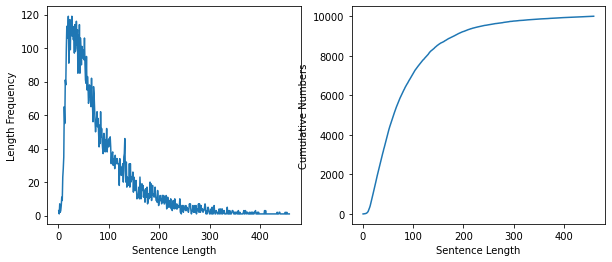

In [33]:
plt.figure(figsize=(10,4))
len_cnt = Counter([len(feats) for feats in train_feats])
len_key = sorted(len_cnt)
plt.subplot(1,2,1)
plt.plot(range(1, len(len_key)+1),
         [len_cnt[l] for l in len_key])
plt.xlabel("Sentence Length")
plt.ylabel("Length Frequency")

plt.subplot(1,2,2)
plt.plot(range(1, len(len_key)+1),
         np.cumsum([len_cnt[l] for l in len_key]))
plt.xlabel("Sentence Length")
plt.ylabel("Cumulative Numbers")

In [34]:
max_len = 100

# build the feats_matrix
# convert each example to a index vector, and then stack vectors as a matrix
train_feats_matrix = np.vstack([get_index_vector(f, feats_dict, max_len) for f in train_feats])
valid_feats_matrix = np.vstack([get_index_vector(f, feats_dict, max_len) for f in valid_feats])

# train_feats_matrix = np.vstack([get_index_vector(f, feats_dict, len(feats_dict)) for f in train_feats])
# valid_feats_matrix = np.vstack([get_index_vector(f, feats_dict, len(feats_dict)) for f in valid_feats])

# convert labels to label_matrix
num_classes = max(train_labels)
# convert each label to a ont-hot vector, and then stack vectors as a matrix
train_label_matrix = keras.utils.to_categorical(train_labels-1, num_classes=num_classes)
valid_label_matrix = keras.utils.to_categorical(valid_labels-1, num_classes=num_classes)

In [35]:
print(train_feats_matrix.shape)
print(valid_feats_matrix.shape)
print(train_label_matrix.shape)
print(valid_label_matrix.shape)

(10000, 100)
(2000, 100)
(10000, 5)
(2000, 5)


In [36]:
num_classes

5

CNN

In [40]:
os.makedirs("models", exist_ok=True)
model = build_CNN(input_length=max_len, vocab_size=len(feats_dict),
                  embedding_size=100, hidden_size=100, output_size=num_classes,
                  kernel_sizes=[1,2,3,4], num_filters=100, num_mlp_layers=3,
                  activation="relu")
checkpointer = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join("models", "weights.hdf5"),
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
earlystopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=0)

np.random.seed(0)
tf.random.set_seed(0)
cnn_history = model.fit(train_feats_matrix, train_label_matrix,
                    validation_split=0.1,
                    epochs=100, batch_size=100, verbose=0,
                    callbacks=[checkpointer, earlystopping, reduce_lr])
model = keras.models.load_model(os.path.join("models", "weights.hdf5"))

train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                             batch_size=100)
valid_score = model.evaluate(valid_feats_matrix, valid_label_matrix,
                            batch_size=100)
print("training loss:", train_score[0], "training accuracy", train_score[1])
print("Valid loss:", valid_score[0], "Valid accuracy", valid_score[1])


Epoch 00014: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.

Epoch 00018: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
20/20 [==============================] - 0s 4ms/step - loss: 1.0010 - accuracy: 0.5730
training loss: 0.7852596640586853 training accuracy 0.6880000233650208
Valid loss: 1.0010424852371216 Valid accuracy 0.5730000138282776


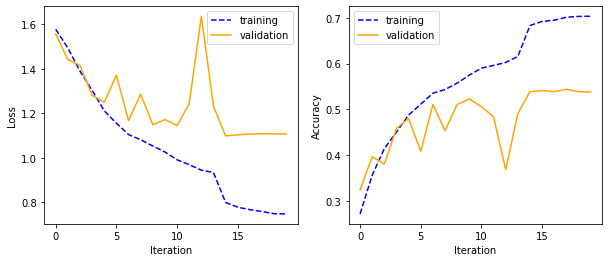

In [41]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(cnn_history.history["loss"], label="training", color="blue", linestyle="dashed")
plt.plot(cnn_history.history["val_loss"], label="validation", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(cnn_history.history["accuracy"], label="training", color="blue", linestyle="dashed")
plt.plot(cnn_history.history["val_accuracy"], label="validation", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Compare optimizers RMSprop, SGD and Adam

In [45]:
checkpointer = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join("models", "weights.hdf5"),
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=0)
earlystopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=0)

np.random.seed(0)
tf.random.set_seed(0)

In [47]:
optimizers = ["SGD", "RMSprop", "Adam"]
for o in optimizers:
    checkpointer = keras.callbacks.ModelCheckpoint(
        filepath=os.path.join("models", "weights" + o + ".hdf5"),
        monitor="val_accuracy",
        verbose=0,
        save_best_only=True)
    model = build_CNN(input_length=max_len, vocab_size=len(feats_dict),
                  embedding_size=100, hidden_size=100, output_size=num_classes,
                  kernel_sizes=[1,2,3,4], num_filters=100, num_mlp_layers=3,
                  activation="relu", optimizer=o)
    cnn_history = model.fit(train_feats_matrix, train_label_matrix,
                    validation_split=0.1,
                    epochs=100, batch_size=100, verbose=0,
                    callbacks=[checkpointer, earlystopping, reduce_lr])
    model = keras.models.load_model(os.path.join("models", "weights" + o + ".hdf5"))

    train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                                batch_size=100)
    valid_score = model.evaluate(valid_feats_matrix, valid_label_matrix,
                                batch_size=100)
    print("training loss:", train_score[0], "training accuracy", train_score[1])
    print("Valid loss:", valid_score[0], "Valid accuracy", valid_score[1])
    

20/20 [==============================] - 0s 4ms/step - loss: 1.0126 - accuracy: 0.5685
training loss: 0.8024972081184387 training accuracy 0.6796000003814697
Valid loss: 1.0125725269317627 Valid accuracy 0.5684999823570251
20/20 [==============================] - 0s 4ms/step - loss: 1.2399 - accuracy: 0.5580
training loss: 0.3769712746143341 training accuracy 0.8802000284194946
Valid loss: 1.239924669265747 Valid accuracy 0.5580000281333923
20/20 [==============================] - 0s 4ms/step - loss: 1.0638 - accuracy: 0.5660
training loss: 0.4513801634311676 training accuracy 0.8411999940872192
Valid loss: 1.0638196468353271 Valid accuracy 0.5659999847412109


Looks like SGD performs the best

Test out different kernel sizes

In [49]:
kernel_size = [[1], [1, 2], [1, 2, 3], [1, 2, 3, 4]]
for k in kernel_size:
    checkpointer = keras.callbacks.ModelCheckpoint(
        filepath=os.path.join("models", "weights" + str(len(k)) + ".hdf5"),
        monitor="val_accuracy",
        verbose=0,
        save_best_only=True)
    model = build_CNN(input_length=max_len, vocab_size=len(feats_dict),
                  embedding_size=100, hidden_size=100, output_size=num_classes,
                  kernel_sizes=k, num_filters=100, num_mlp_layers=3,
                  activation="relu")
    cnn_history = model.fit(train_feats_matrix, train_label_matrix,
                    validation_split=0.1,
                    epochs=100, batch_size=100, verbose=0,
                    callbacks=[checkpointer, earlystopping, reduce_lr])
    model = keras.models.load_model(os.path.join("models", "weights" + str(len(k)) + ".hdf5"))

    print("Kernels used", k)

    train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                                batch_size=100)
    valid_score = model.evaluate(valid_feats_matrix, valid_label_matrix,
                                batch_size=100)
    print("training loss:", train_score[0], "training accuracy", train_score[1])
    print("Valid loss:", valid_score[0], "Valid accuracy", valid_score[1])

Kernels used [1]
20/20 [==============================] - 0s 3ms/step - loss: 1.0366 - accuracy: 0.5535
training loss: 0.8975844979286194 training accuracy 0.6269999742507935
Valid loss: 1.0365687608718872 Valid accuracy 0.5534999966621399
Kernels used [1, 2]
20/20 [==============================] - 0s 3ms/step - loss: 1.0099 - accuracy: 0.5750
training loss: 0.815551221370697 training accuracy 0.6686999797821045
Valid loss: 1.0099023580551147 Valid accuracy 0.574999988079071
Kernels used [1, 2, 3]
20/20 [==============================] - 0s 4ms/step - loss: 1.0162 - accuracy: 0.5695
training loss: 0.8110384345054626 training accuracy 0.6761000156402588
Valid loss: 1.0161689519882202 Valid accuracy 0.5695000290870667
Kernels used [1, 2, 3, 4]
20/20 [==============================] - 0s 4ms/step - loss: 1.0181 - accuracy: 0.5695
training loss: 0.7874174118041992 training accuracy 0.6888999938964844
Valid loss: 1.0180799961090088 Valid accuracy 0.5695000290870667


Looks like kernels [1, 2] are enough

Test batch normalization, dropout and regularization

In [53]:
bn = [False, True]
drop = [0.25, 0.5, 0.75]
reg = [0.005, 0.05, 0.5]

for b in bn:
    for d in drop:
        for r in reg:
            checkpointer = keras.callbacks.ModelCheckpoint(
              filepath=os.path.join("models", "weights_" + str(b)+ "_" + str(d) + "_" + str(r) + ".hdf5"),
              monitor="val_accuracy",
              verbose=0,
              save_best_only=True)
            model = build_CNN(input_length=max_len, vocab_size=len(feats_dict),
                          embedding_size=100, hidden_size=100, output_size=num_classes,
                          kernel_sizes=[1, 2], num_filters=100, num_mlp_layers=3,
                          activation="relu", dropout_rate=d, l2_reg=r, batch_norm=b)
            cnn_history = model.fit(train_feats_matrix, train_label_matrix,
                            validation_split=0.1,
                            epochs=100, batch_size=100, verbose=0,
                            callbacks=[checkpointer, earlystopping, reduce_lr])
            model = keras.models.load_model(os.path.join("models", "weights_" + str(b)+ "_" + str(d) + "_" + str(r) + ".hdf5"))

            print("weights_" + str(b)+ "_" + str(d) + "_" + str(r) + ".hdf5")

            train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                                        batch_size=100)
            valid_score = model.evaluate(valid_feats_matrix, valid_label_matrix,
                                        batch_size=100)
            print("training loss:", train_score[0], "training accuracy", train_score[1])
            print("Valid loss:", valid_score[0], "Valid accuracy", valid_score[1])

weights_False_0.25_0.005.hdf5
20/20 [==============================] - 0s 3ms/step - loss: 1.1324 - accuracy: 0.5630
training loss: 1.0280522108078003 training accuracy 0.6273999810218811
Valid loss: 1.1323556900024414 Valid accuracy 0.5630000233650208
weights_False_0.25_0.05.hdf5
20/20 [==============================] - 0s 3ms/step - loss: 1.1054 - accuracy: 0.5505
training loss: 1.0791494846343994 training accuracy 0.5679000020027161
Valid loss: 1.105401873588562 Valid accuracy 0.5504999756813049
weights_False_0.25_0.5.hdf5
20/20 [==============================] - 0s 3ms/step - loss: 1.5890 - accuracy: 0.2585
training loss: 1.5904090404510498 training accuracy 0.2533999979496002
Valid loss: 1.5889817476272583 Valid accuracy 0.25850000977516174
weights_False_0.5_0.005.hdf5
20/20 [==============================] - 0s 3ms/step - loss: 1.0381 - accuracy: 0.5840
training loss: 0.8601505756378174 training accuracy 0.6739000082015991
Valid loss: 1.0380795001983643 Valid accuracy 0.583999991

Best Model - BN=True, Drop=0.25, l2req=0.05